In [1]:
from struct import unpack
import gzip
from numpy import zeros, uint8, float32

def get_labeled_data():
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    # Open the images with gzip in read binary mode
    images = gzip.open('t10k-images-idx3-ubyte.gz', 'rb')
    labels = gzip.open('t10k-labels-idx1-ubyte.gz', 'rb')

    # Read the binary data

    # We have to get big endian unsigned int. So we need '>I'

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)  # skip the magic_number
    N = labels.read(4)
    N = unpack('>I', N)[0]

    if number_of_images != N:
        raise Exception('number of labels did not match the number of images')

    # Get the data
    x = zeros((N, rows, cols), dtype=float32)  # Initialize numpy array
    y = zeros((N, 1), dtype=uint8)  # Initialize numpy array
    for i in range(N):
        if i % 1000 == 0:
            print("i: %i" % i)
        for row in range(rows):
            for col in range(cols):
                tmp_pixel = images.read(1)  # Just a single byte
                tmp_pixel = unpack('>B', tmp_pixel)[0]
                x[i][row][col] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]
    return (x, y)
x_train, y_train = get_labeled_data(5,5)

i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000


In [2]:
import numpy as np 
img_np = []
for tr in x_train:
    tr = np.array(tr)
    tr = tr.reshape(784,)
    
    img_np.append(tr)
img_np = np.array(img_np)         

In [3]:
answers = y_train
print len(y_train)
ans = []
for i in range(0,len(y_train)):
    item = [0]*10
    item[answers[i]] = 1
    ans.append(item)
ans  = np.array(ans)
print ans.shape
print ans

10000
(10000, 10)
[[0 0 0 ..., 1 0 0]
 [0 0 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


/home/fsftn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [5]:
def TRAIN_SIZE(num):
    print ('Total Training Images in Dataset = ' + str(img_np.shape))
    print ('--------------------------------------------------')
    x_train = img_np[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = np.array(ans[:num])
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train
def TEST_SIZE(num):
    print ('Total Test Examples in Dataset = ' + str(img_np.shape))
    print ('--------------------------------------------------')
    x_test = img_np[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = ans[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test

In [6]:
print ans.shape
x_train, y_train = TRAIN_SIZE(8500)
x_test, y_test = TEST_SIZE(100)

(10000, 10)
Total Training Images in Dataset = (10000, 784)
--------------------------------------------------
x_train Examples Loaded = (8500, 784)
y_train Examples Loaded = (8500, 10)

Total Test Examples in Dataset = (10000, 784)
--------------------------------------------------
x_test Examples Loaded = (100, 784)
y_test Examples Loaded = (100, 10)


In [7]:
from sklearn.utils import shuffle
losses = []
import tensorflow as tf
sess = tf.Session()

x_train_batch = [0]*1
y_train_batch = [0]*1


x = tf.placeholder(tf.float32, [None, 784])

#W = tf.Variable(tf.truncated_normal([175561,2], stddev= 0.6))
W = tf.Variable(tf.zeros([784, 10]))
 
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x,W) + b) + 0.0000001
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_sum(-tf.reduce_sum( y_ *tf.log(y) , reduction_indices =[1]))

train_step = tf.train.AdamOptimizer(0.3125).minimize(cross_entropy)
init = tf.global_variables_initializer()
sess.run(init)

for k in range(0,4):
    
    x_train, y_train = shuffle(x_train,y_train)
    
    for i in range(0,6000,6000):
        #print i 
        x_train_batch[i/200] = x_train[i:i+6000]
        y_train_batch[i/200] = y_train[i:i+6000]

    for i in range(0,len(x_train_batch)):
        #print i, x_train_batch[i]
        x_train_batch[i] = np.array(x_train_batch[i]).reshape(len(x_train_batch[i]),784)
        y_train_batch[i] = np.array(y_train_batch[i]).reshape(len(y_train_batch[i]),10)

    for j in range(0,len(x_train_batch)):
        _,wval,loss = sess.run([train_step,W,cross_entropy], feed_dict={x: x_train_batch[j], y_: y_train_batch[j]})
        print (loss)
        losses.append(loss)
        #print x_train_batch[i]

    print '-----------------------'

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print 'accuracy ', (sess.run(accuracy, feed_dict={x: x_test, y_: y_test}))

13815.3
-----------------------
37514.9
-----------------------
35320.2
-----------------------
34752.2
-----------------------
accuracy  0.61


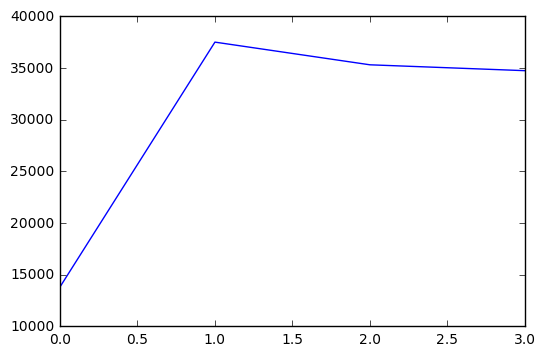

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()